In [2]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

#общие штуки для кручения данных
import pandas as pd
import pandahouse
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров

<h1>1.Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?</h1>

- За основную метрику возьмем количество действий(action), так как эта метрика довольно хорошо отображает активность пользователей, чем больше у нас произошло лайков и просмотров, тем активнее пользователи. Также можно было бы взять количество активных пользователей в час, но у пользователей может быть разная степень активности.  
- Разрешение будет в один час, тк это самый оптимальный вариант. Если брать в течении дня, то активность может распределиться неравномерно. Если брать в секунду ,то будет слишком много данных. 
- В следующие 30 дней не ожидается больших праздников или других причин, которые могут повлиять на наши данные, поэтому регрессоры не нужны

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230820',
'user':'student',
'password':'dpo_python_2020'
}

In [4]:
q = """
SELECT count(action) as count_action,
    toStartOfHour(time) as Date
FROM {db}.feed_actions 
WHERE toDate(time) < today() - 1

GROUP BY toStartOfHour(time)
ORDER BY toStartOfHour(time)
"""

activity = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
activity

,count_action,Date
0,22,2023-07-03 00:00:00
1,32,2023-07-03 01:00:00
2,24,2023-07-03 02:00:00
3,11,2023-07-03 03:00:00
4,18,2023-07-03 04:00:00
...,...,...
1627,53464,2023-09-08 19:00:00
1628,47554,2023-09-08 20:00:00
1629,45930,2023-09-08 21:00:00
1630,39425,2023-09-08 22:00:00


<h1>2.Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.</h1>

<font size=4>Данных для бэктестинга хватает впритык. У нас имеется данных за два месяца, прогнозирование нужно сделать на месяц, получается соотношение 1/2 или 33/66, в идеале должно быть соотношение 20/80 или 30/70. Если смотреть горизонт прогнозирования "в идеале", то наших данных хватит на 15 дней (20/80) или 26 дней(30/70)</font>

<h3>Выведем данные для двух оcновных моделей:</h3>

- map
- mcmc

<h2>map</h2>



In [6]:
dlt = DLT(response_col="count_action", #название колонки с метрикой
          date_col="Date", #название колонки с датами-временем
          seasonality=24, #длина периода сезонности 
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2023-09-10 14:26:37 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


<h3>Определим наилучший damped_factor</h3>

In [7]:
best_params, tuned_df = grid_search_orbit(param_grid={"damped_factor": np.arange(0.1, 1.0, 0.1)}, #наш параметр
                                        model=dlt,
                                        df=activity,
                                        min_train_len=20*24,
                                        incremental_len=4*24,
                                        forecast_len=4*24,
                                        metrics=None, #смотрим smape по умолчанию
                                        criteria="min", #говорим, что нам нужна минимизация
                                        verbose=True) #пусть печатает процесс выполнения

  0%|          | 0/9 [00:00<?, ?it/s]

2023-09-10 14:26:37 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1}
2023-09-10 14:26:37 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-09-10 14:26:54 - orbit - INFO - tuning metric:0.25468
2023-09-10 14:26:54 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2}
2023-09-10 14:26:54 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-09-10 14:27:12 - orbit - INFO - tuning metric:0.25363
2023-09-10 14:27:12 - orbit - INFO - tuning hyper-params {'damped_factor': 0.30000000000000004}
2023-09-10 14:27:12 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-09-10 14:27:32 - orbit - INFO - tuning metric:0.25519
2023-09-10 14:27:32 - orbit - INFO - tuning hyper-params {'damped_factor': 0.4}
2023-09-10 14:27:32 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-09-10 14:27:49 - orbit - INFO - tuning metric:0.25462
2023-09-10 14:27:49 - orbit - INFO - tuning hyper-params {'damped_factor': 0.5}
2023-09-10 14:27:49 - orbit 

In [8]:
tuned_df

,damped_factor,metrics
0,0.1,0.254677
1,0.2,0.253633
2,0.3,0.255191
3,0.4,0.254618
4,0.5,0.252306
5,0.6,0.258306
6,0.7,0.254037
7,0.8,0.248436
8,0.9,0.261111


Тк по умолчанию damped_factor=0.8, менять ничего не будем

<h3>Проведем бэктест для map</h3>

In [34]:
bt_roll = BackTester(
    model=dlt,
    df=activity,
    min_train_len=20*24,
    incremental_len=4*24,
    forecast_len=4*24,
    window_type="rolling",
)

In [35]:
bt_roll.fit_predict() #обучаем
bt_roll.score()

,metric_name,metric_values,is_training_metric
0,smape,2.594021e-01,False
1,wmape,2.794313e-01,False
2,mape,2.964829e-01,False
3,mse,2.305745e+08,False
4,mae,9.020013e+03,False
5,rmsse,3.207034e+00,False


<h3>В целом метрики показали не самый хороший результат, тем не менее получилось неплохое значение smape примерно 0.259</h3>

In [11]:
dlt.fit(activity) #тут мы указываем данные, на которых строится модель

In [12]:
future_df_map = dlt.make_future_df(periods=30*24) 
#горизонт будет 30 дней

In [13]:
predicted_df_map = dlt.predict(df=future_df_map)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

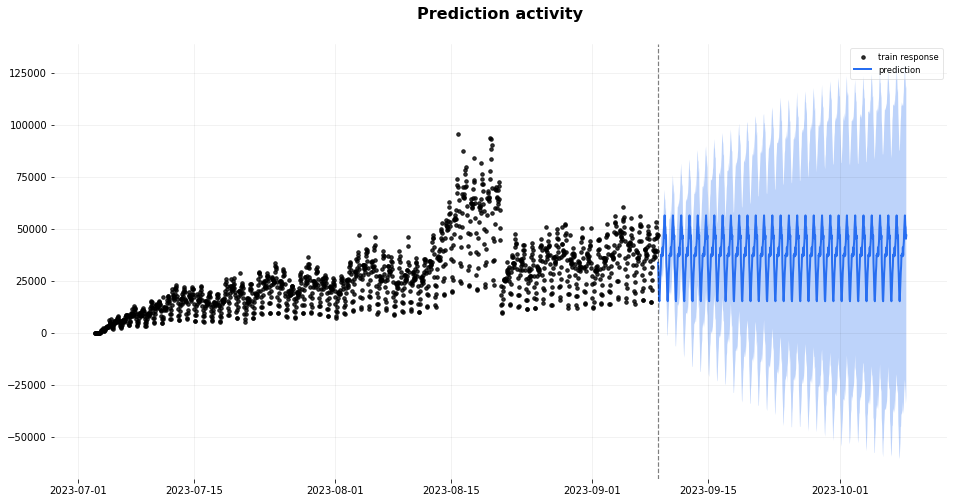

In [14]:
_ = plot_predicted_data(activity, #изначальные данные
                        predicted_df_map, #датафрейм с предсказаниями
                        "Date", #колонка со временем
                        'count_action', #колонка со значениями временного ряда
                        title='Prediction activity') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

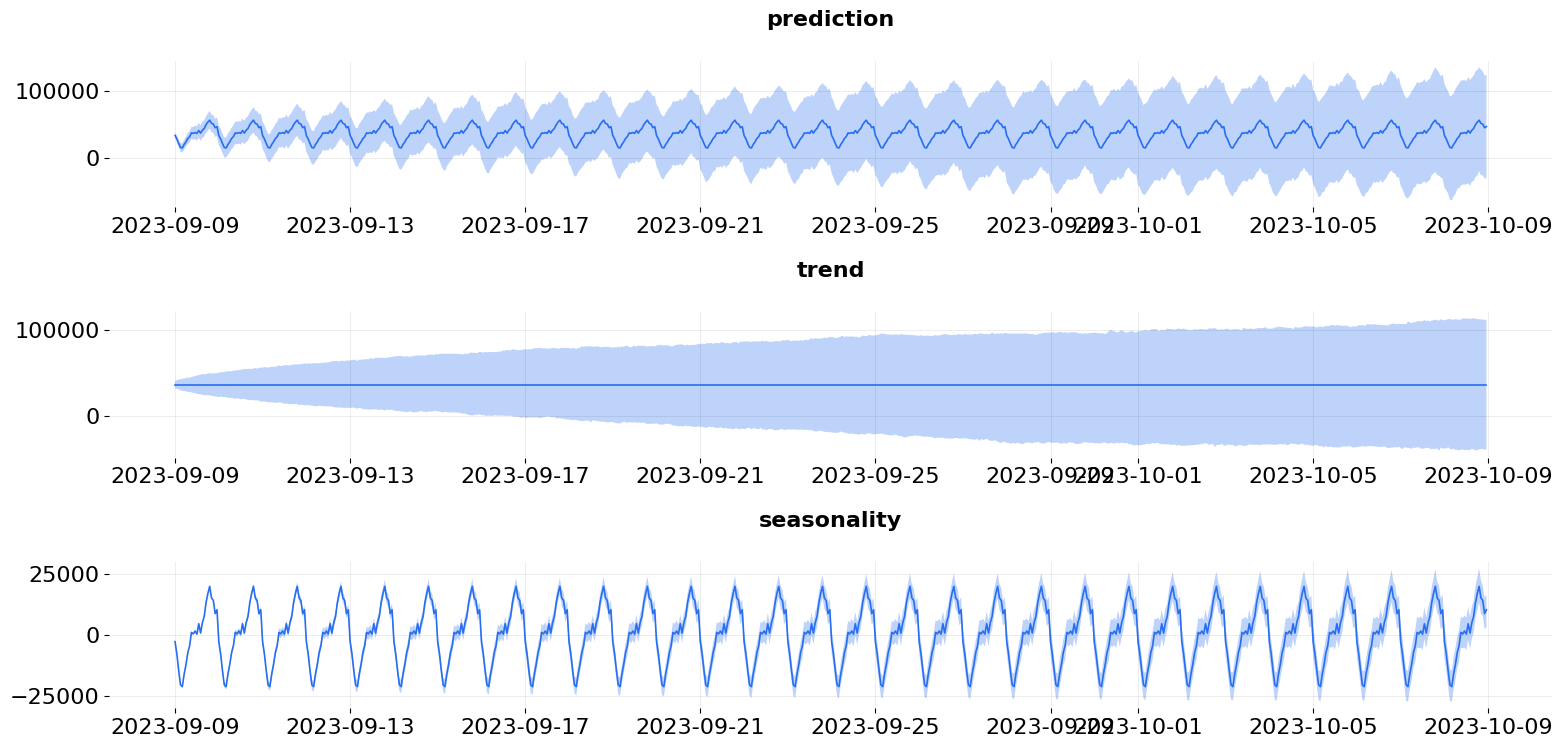

In [15]:
predicted_map = dlt.predict(df=future_df_map, 
                           decompose=True) #говорит, что нам нужна декомпозиция предсказания

_ = plot_predicted_components(predicted_map, 
                              "Date", 
                              plot_components=['prediction', 'trend', 'seasonality'])

<h2>mcmc</h2>

<h3>Проведем z-стандартизацию данных, тк без нее цепи алгоритма не сходятся</h3>

In [33]:
activity["count_action_z"]=(activity["count_action"]-activity["count_action"].mean())/activity["count_action"].std()
a_mean=activity["count_action"].mean()
a_std=activity["count_action"].std()
activity

,count_action,Date,count_action_z
0,22,2023-07-03 00:00:00,-1.640615
1,32,2023-07-03 01:00:00,-1.639991
2,24,2023-07-03 02:00:00,-1.640490
3,11,2023-07-03 03:00:00,-1.641301
4,18,2023-07-03 04:00:00,-1.640864
...,...,...,...
1627,53464,2023-09-08 19:00:00,1.693196
1628,47554,2023-09-08 20:00:00,1.324519
1629,45930,2023-09-08 21:00:00,1.223211
1630,39425,2023-09-08 22:00:00,0.817417


In [43]:
dlt_mcmc = DLT(seasonality=24, 
               response_col="count_action_z", 
               date_col="Date", 
               estimator='stan-mcmc', #новый алгоритм оценки
               num_warmup=4000, #время "разогрева"
               num_sample=2000,
              global_trend_option= "loglinear")

Оставим damped_factor без изменения,тк алгоритм mcmc тратит очень много времени на выявление лучшего damped_factor

<h3>Бэктест для mcmc</h3>

In [44]:
bt_roll_mcmc = BackTester(
    model=dlt_mcmc,
    df=activity,
    min_train_len=20*24,
    incremental_len=4*24,
    forecast_len=4*24,
    window_type="rolling",
)

In [45]:
bt_roll_mcmc.fit_predict() #обучаем

2023-09-10 12:30:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:32:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:35:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:37:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:39:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:44:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:47:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:49:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:52:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:54:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-10 12:56:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [49]:
bt_roll_mcmc.score()

,metric_name,metric_values,is_training_metric
0,smape,0.871683,False
1,wmape,0.616501,False
2,mape,3.238799,False
3,mse,0.410989,False
4,mae,0.448325,False
5,rmsse,2.170475,False


<h4>Метрики получились плохие</h4> 

<h4>Дополнительная проверка mcmc</h4>

In [48]:
dlt_mcmc.fit(activity)

2023-09-10 13:01:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

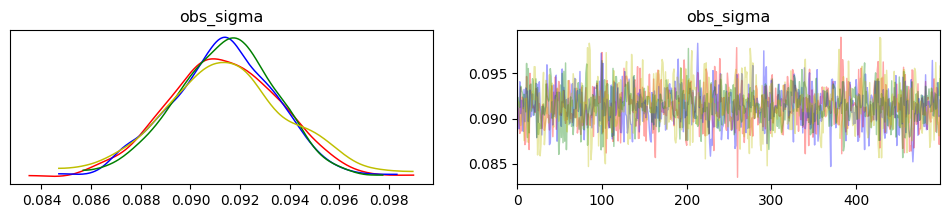

In [50]:
params = dlt_mcmc.get_posterior_samples(permute=False) #достаём информацию о параметрах
params.keys()

params["obs_sigma"].shape #лучше смотреть те, у которых третьего измерения либо нет, либо оно равно 1

az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

<h3>Метод mcmc c z-cтандартизацией сошелся</h3>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

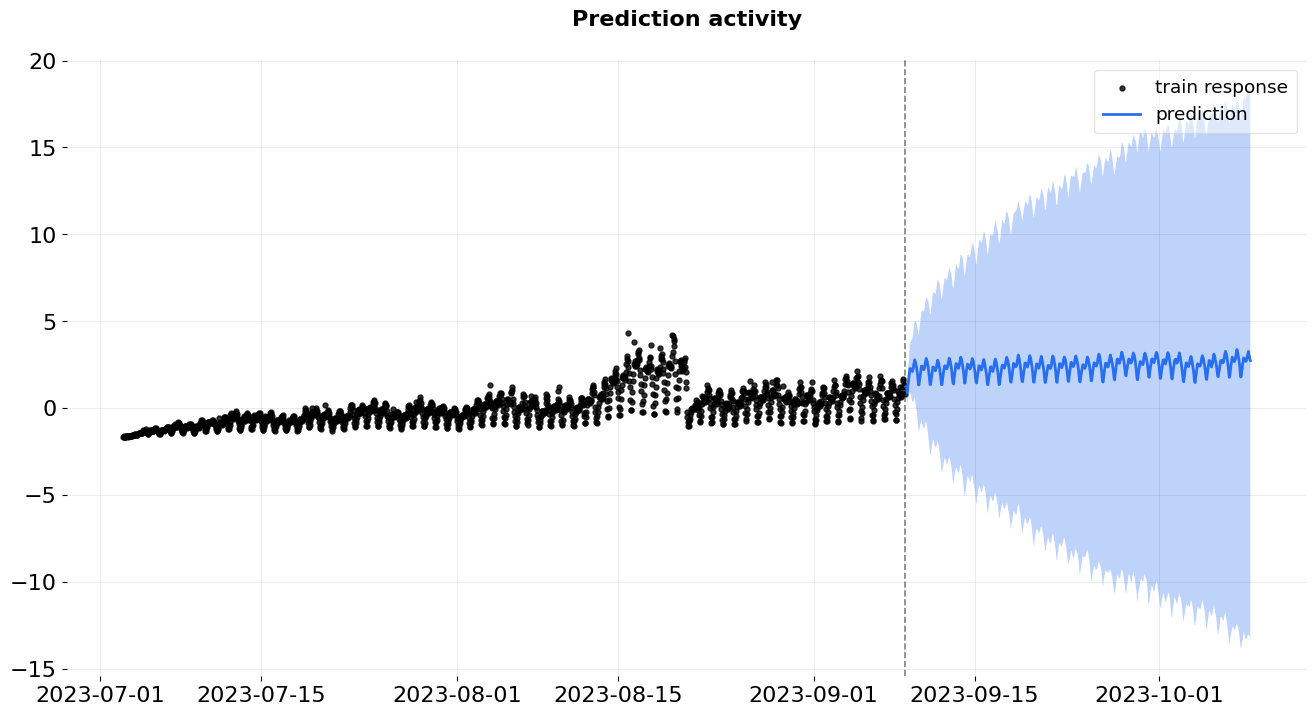

In [51]:
future_df_mcmc = dlt_mcmc.make_future_df(periods=24*30)

predicted_df_mcmc = dlt_mcmc.predict(df=future_df_mcmc)

_ = plot_predicted_data(activity, predicted_df_mcmc, "Date", 'count_action_z', title='Prediction activity')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

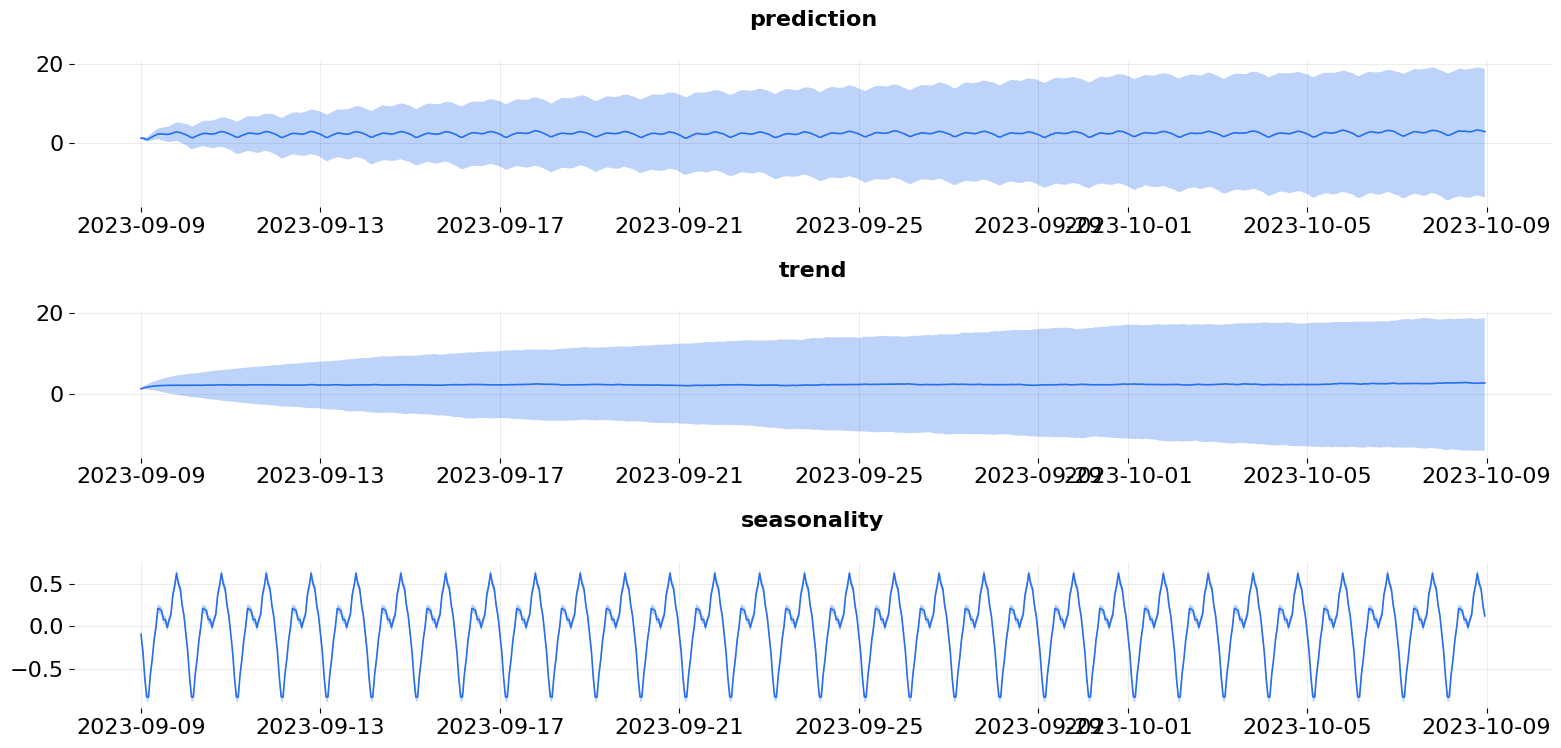

In [53]:
predicted_mcmc = dlt_mcmc.predict(df=future_df_mcmc, 
                           decompose=True) #говорит, что нам нужна декомпозиция предсказания

_ = plot_predicted_components(predicted_mcmc, 
                              "Date", 
                              plot_components=['prediction', 'trend', 'seasonality'])

<h1>3.Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.</h1>

- В данном случае предпочтительнее выбрать модель map, тк mcmc с z-сдандатизаие имеет более плохие метрики оценки качества модели и имеет скачек в прогнозе. Также mcmc затрачивает гораздо больше времени на работу
- map показал на бэктесте smape=0.259. mcmc показали smape=0.871.
- По прогнозу map можно видеть что значение предсказания 15 сентября = 56560 действий/час, 25 сентября =56553 действий/час и 5 октября = 56546. В целом прогноз стабилен
- Максимальным значением прогноза, если брать верхнее значение доверительного 15 сентября = 94547 действий/час, 25 сентября =116035 действий/час и 5 октября = 127405.
- Значение тренда стабильно и в среднем равно 36452
- Хотелось добавить, что прогноз map возможно является не совсем корректным в силу того, что не имеет роста. Если посмотреть на актуальные данные, то мы наблюдаем постоянный рост, однако прогноз map стабилен и горизонтален, отсюда можно сделать вывод, что данные прогноза занижены, поэтому главный параметр на который нам нужно смотреть это верхнее значение доверительного интервала и надо быть готовым, что количество действий может увеличиться до 130 тыс действий в час к концу прогнозируемого периода. 
- Также нужно учесть такие события, как флешмобы и тд, которые увеличивают активность пользователей и соответственно увеличивают нагрузку на сервер, поэтому с учетом таких вещей значение 130 тыс дейст/час через месяц возможно является неплохих


In [29]:
predicted_map["trend"].mean()

36452.954390530285

In [18]:
predicted_map[(predicted_map["Date"]>="2023-09-15 00:00:00") & (predicted_map["Date"]<"2023-09-16 00:00:00")]["prediction"].max()

56560.79841389451

In [19]:
predicted_map[(predicted_map["Date"]>="2023-09-25 00:00:00") & (predicted_map["Date"]<"2023-09-26 00:00:00")]["prediction"].max()

56553.78281389451

In [26]:
predicted_map[(predicted_map["Date"]>="2023-10-05 00:00:00") & (predicted_map["Date"]<"2023-10-06 00:00:00")]["prediction"].max()

56546.76721389451

In [21]:
predicted_map[(predicted_map["Date"]>="2023-09-15 00:00:00") & (predicted_map["Date"]<"2023-09-16 00:00:00")]["prediction_95"].max()

94547.77036347649

In [23]:
predicted_map[(predicted_map["Date"]>="2023-09-25 00:00:00") & (predicted_map["Date"]<"2023-09-26 00:00:00")]["prediction_95"].max()

116035.59827850353

In [25]:
predicted_map[(predicted_map["Date"]>="2023-10-05 00:00:00") & (predicted_map["Date"]<"2023-10-06 00:00:00")]["prediction_95"].max()

127405.37788434404